<a href="https://colab.research.google.com/github/GiovaniValdrighi/style_transfer/blob/main/notebooks/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Style transfer neural network

In [15]:
import torch
import urllib
import torch.nn as nn
from PIL import Image
from torchvision import transforms
import torch.optim as optim
from torchvision.models import vgg19
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

Downloading from torch the pre-trained CNN VGG19.

In [16]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'vgg19', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.6.0', 'vgg19_bn', pretrained=True)
model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

Opening a sample image from torch.

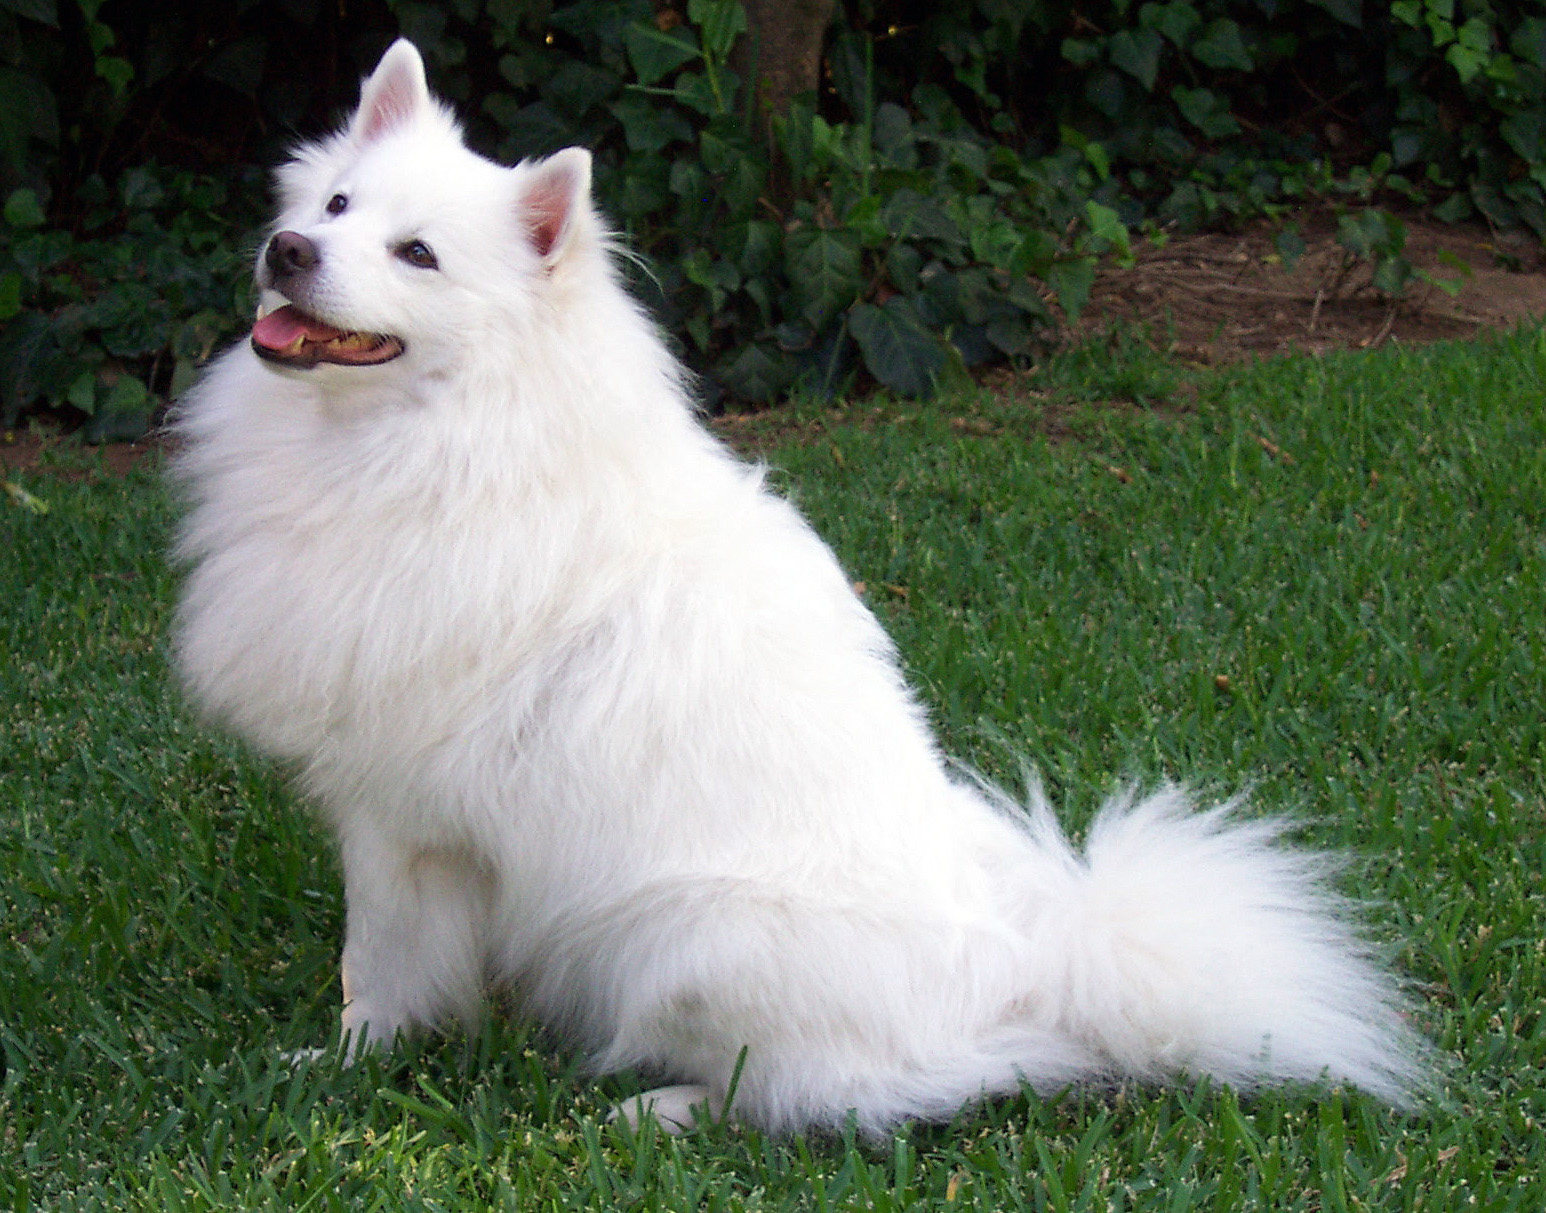

In [17]:
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
urllib.request.urlretrieve(url, filename)
input_image = Image.open(filename)
input_image

In [18]:
#image must have shape (3 x H x W), with H > 224, W > 224
#images range on [0, 1],  normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].
#preprocess is the function that will adjust our input image

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
print(torch.nn.functional.softmax(output[0], dim=0).argmax())

tensor(258, device='cuda:0')


And according to Imagenet's 1000 classes, we have the class 258 to be ['Samoyed, Samoyede'], and our picture is a really cute Samoyed.

## Neural style transfer

## Preprocess images


In [19]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def load_image(path):
    '''Function that load the image and preprocess to the VGG19 format
    The image must be with shape 224x224, with mean [0.485, 0.456, 0.406]
    and standard deviation [0.229, 0.224, 0.225]'''
    img = Image.open(path)
    return preprocess(img).unsqueeze(0)


## Loss functions

In [20]:
def content_loss(pred, target):
    '''The content loss is the mean squared error'''
    return torch.pow(pred - target, 2).mean()

def gram_matrice(input):
    '''
    Compute the gram matrice of the input tensor
    The gram matrice of V is V'V, but we have to change the input to 2 dimensios
    Than we normalize by the number of elements
    '''
    batch, channel, width, height = input.size()
    M = input.view(batch * channel, width * height)
    gram = torch.mm(M, M.t())
    return gram.div(batch*width*height*channel)

def style_loss(pred, gram_target):
    '''The style loss if the euclidian distance of the Gram matrice '''
    gram_pred = gram_matrice(pred)
    return torch.pow(gram_pred - gram_target, 2).mean()

## Model

In [21]:
class vgg19_mod(nn.Module):
    def __init__(self, content_layers, style_layers):
        '''
        Class that initialize the VGG19 model and set the intermediate style and content layers

        Inputs:
            style_layers : list of index of the style layers in the VGG19 net
            content_layers: list of index of the content layers in the VGG19 net
        '''
        super(vgg19_mod, self).__init__()
        features = list(vgg19(pretrained = True).features)
        self.features = nn.ModuleList(features).eval()
        self.style_layers = style_layers
        self.content_layers = content_layers

    def forward(self,  input):
        '''
        Forward process that pass the input image trought the VGG 19 net and keeps the intermediates outputs

        Inputs:
            input : tensor of shape [batch, 3, 224, 224] 

        Outputs:
            style_out : list of style layers outputs
            cotent_out : list of content layers outputs
        '''
        style_out = []
        content_out = []
        for i, model in enumerate(self.features):
            input = model(input)
            if i in self.style_layers:
                style_out.append(input)
            if i in self.content_layers:
                content_out.append(input)
        return content_out, style_out


In [22]:
content_layers_default = [9]
style_layers_default = [0, 3, 6, 9, 14]

## Training

In [23]:
def run_style_transfer(content_path, style_path, iterations = 500, content_layers = None, style_layers = None, 
                       content_weight = 1, style_weight = 1000000, verbose = False, cuda = False):
    '''
    Training process for the neural style transfer VGG19
    The method uses two images, the content and the style image, and generate a image that 
    contain the content and the style of the reespective images
    The optimization is done by LBFGS

    Inputs:
        content_path : path for the content image
        style_path : path for the style image
        iterations: number of iterations to converge
        content_layers : list of index of VGG19 content layers
        style_layers : list of index of VGG19 style layers
        content_weight : weight of the content loss
        style_weight : weight of the style loss
        verbose : if the function will print intermediate steps

    Outputs:
        init_image : result image with content and style

    '''
    if cuda:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        if verbose:
            print("Running model with", device)
    else:
        device = torch.device('cpu')

    #Setting intermediate layers
    if content_layers is None:
        content_layers = [9]

    if style_layers is None:
        style_layers = [0, 3, 6, 9, 14]

    #Loading the model
    model = vgg19_mod(content_layers, style_layers).to(device)
        
    if verbose:
        print('Initialized model.')

    #Loading the images as tensors
    content_img = load_image(content_path).to(device)
    style_img = load_image(style_path).to(device)
    init_img = load_image(content_path).to(device)
    if verbose:
        print('Initialized images.')

    #Getting the content and style outputs
    content_out, _ = model(content_img)
    _, style_out = model(style_img)
    if verbose:
        print('Calculated images outputs.')

    #Pre-calculating the gram matrice for the styles outputs
    gram_out = [gram_matrice(out) for out in style_out]

    #Setting optmizer
    optmizer = optim.LBFGS([init_img.requires_grad_()])
    if verbose:
        print('Starting optimization.')
    for iter in tqdm(range(iterations)):

        def closure():
            '''Calculate ouputs, loss and gradients'''
            optmizer.zero_grad()

            init_content_out, init_style_out = model(init_img)
            
            _content_loss = 0
            for l in range(len(content_out)):
                _content_loss += content_loss(init_content_out[l], content_out[l])

            _style_loss = 0
            for l in range(len(style_out)):
                _style_loss += style_loss(init_style_out[l],  gram_out[l])

            _content_loss *= content_weight
            _style_loss *= style_weight

            loss = _content_loss + _style_loss
            loss.backward(retain_graph=True)
            #print(init_img.grad)

            if iter % 100 == 0 and iter > 0:
                if verbose:
                    print('Iteration %d.  Model loss %.8f'%(iter, loss))
                    print('Content loss: %.8f | Style loss: %.8f'%(_content_loss, _style_loss))
                    print()

            return _content_loss + _style_loss
        optmizer.step(closure)

    init_img.data.clamp_(0, 1)
    return init_img

## Training with content and style image

In [27]:
cat_path = '/content/cat.jpg'
stary_night_path = '/content/stary_night.jpg'
images_dict = {1e-2:{}, 1e-1:{}}
for content_weight in [1e-2, 1e-1]:
    for style_weight in [1e5, 1e6]:
        images_dict[content_weight][style_weight] = run_style_transfer(cat_path, stary_night_path, 
                                                                       verbose = False, cuda = True,
                                                                    content_weight = content_weight,
                                                                    style_weight = style_weight)

## Saving the trained model

In [28]:
import pickle as pkl
with open("images_dict.pkl", "wb") as f:
    pkl.dump(images_dict, f)

## Visualizing the results

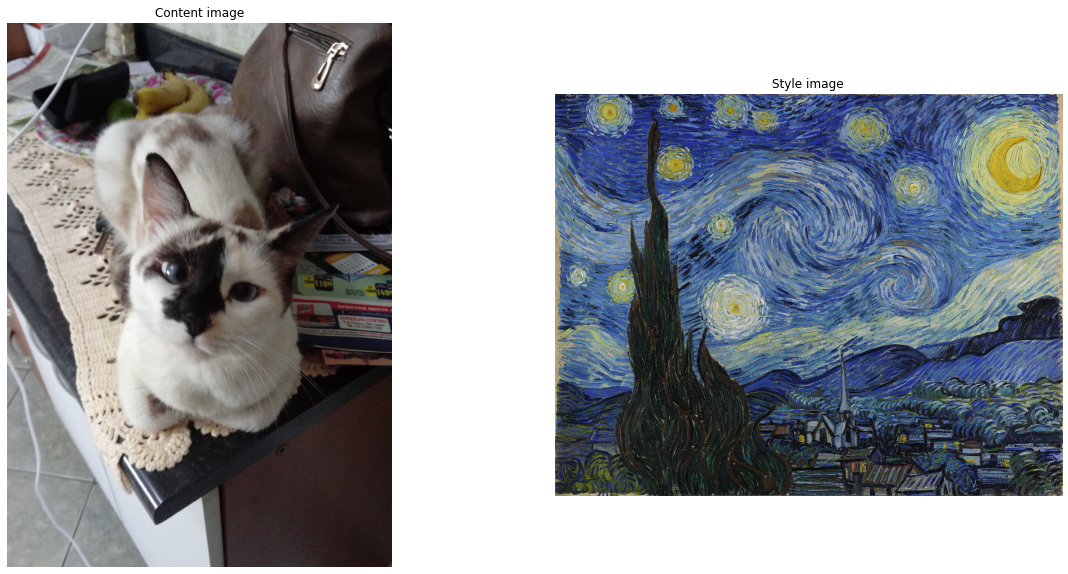

In [42]:
fig, ax = plt.subplots(nrows = 1, ncols = 2)
fig.set_figwidth(20)
fig.set_figheight(10)

ax[0].set_title('Content image')
content_image = Image.open('cat.jpg')
ax[0].imshow(content_image)
ax[0].axis('off')

ax[1].set_title("Style image")
style_image = Image.open('stary_night.jpg')
ax[1].imshow(style_image)
ax[1].axis('off')
plt.show()

In [38]:
ax[0]

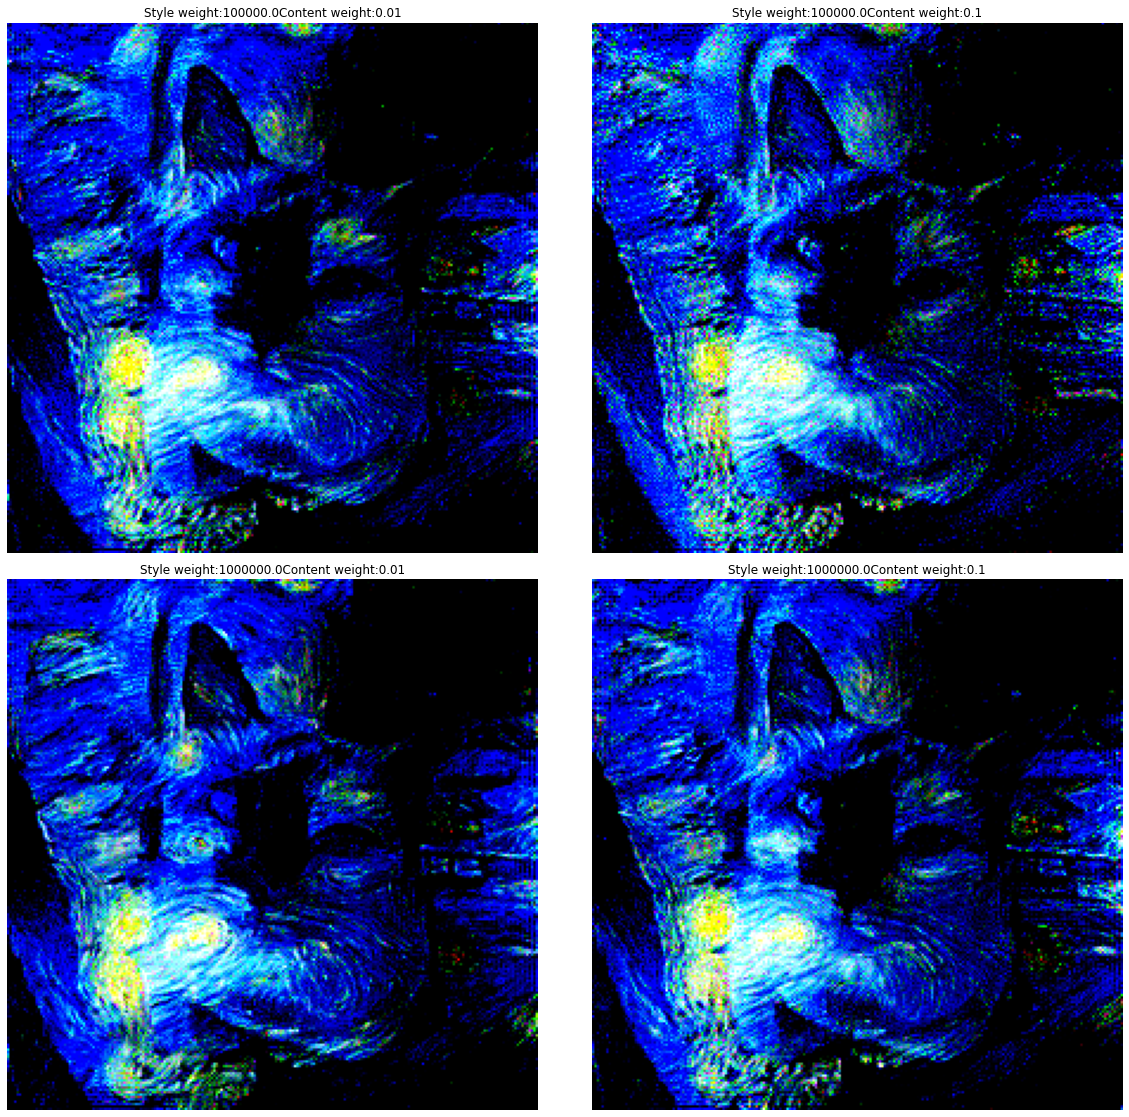

In [35]:
fig, ax = plt.subplots(nrows = 2, ncols = 2)
fig.set_figwidth(20)
fig.set_figheight(20)
for i, style_weight in enumerate([1e5, 1e6]):
    for j, content_weight in enumerate([1e-2, 1e-1]):
        img = images_dict[content_weight][style_weight].cpu().detach().squeeze(0).permute(1, 2, 0).numpy()
        ax[i,j].imshow(img)
        ax[i,j].set_title("Style weight:" + str(style_weight) + "Content weight:"  + str(content_weight))
        ax[i,j].axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.05)
plt.show()